### Compute Metric Example Workflow

In this notebook we showcase how a fictional T&E engineer, Jack, could utilize NRTK and the ImageMetric interface in a workflow.

Jack has identified that the quality of images his model will be receiving is likely to degrade due to a variety of natural pertubations beyond what was initially expected. He wants to use NRTK to explore the direct relationship between image quality and model performance.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.axes import Axes  # type: ignore

import numpy as np
import os
import urllib.request
from PIL import Image
from typing import Iterable, Hashable, Tuple, Any, Dict
from dataclasses import dataclass

from maite.protocols import ArrayLike
from maite.protocols.object_detection import ObjectDetectionTarget

from smqtk_image_io.bbox import AxisAlignedBoundingBox
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN

from nrtk.impls.image_metric.snr_image_metric import SNRImageMetric
from nrtk.impls.score_detections.class_agnostic_pixelwise_iou_scorer import ClassAgnosticPixelwiseIoUScorer
from nrtk.impls.gen_object_detector_blackbox_response.simple_generic_generator import SimpleGenericGenerator
from nrtk.impls.perturb_image_factory.generic.step import StepPerturbImageFactory
from nrtk.impls.perturb_image_factory.generic.linspace_step import LinSpacePerturbImageFactory
from nrtk.impls.perturb_image.generic.skimage.random_noise import PepperNoisePerturber
from nrtk.impls.perturb_image.generic.cv2.blur import GaussianBlurPerturber
from nrtk.impls.perturb_image.generic.PIL.enhance import BrightnessPerturber

from nrtk_jatic.interop.object_detection.augmentation import JATICDetectionAugmentation
from nrtk_jatic.interop.object_detection.dataset import JATICObjectDetectionDataset

In [2]:
@dataclass
class ObjectDetectionData:
    boxes: ArrayLike
    labels: ArrayLike
    scores: ArrayLike
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < len(self.boxes):
            self.n += 1
            return self.boxes[self.n-1], self.labels[self.n-1], self.scores[self.n-1]
        else:
            raise StopIteration

def dets_to_maite(dets: Iterable[Tuple[AxisAlignedBoundingBox, Dict[Hashable, float]]],
                  thresh: float = 0.4) -> ObjectDetectionTarget:
    boxes = []
    labels = []

    for box, probs in dets:
        box_out = box.min_vertex.tolist()
        box_out.extend(box.max_vertex.tolist())

        # Just keep the highest scored prediction
        cls_name = max(probs, key=lambda key: probs[key])
        if probs[cls_name] > thresh:
            cls_idx = list(probs.keys()).index(cls_name)

            boxes.append(box_out)
            labels.append(cls_idx)

    return ObjectDetectionData(
        boxes=np.asarray(boxes, dtype=float),
        labels=np.asarray(labels, dtype=int),
        scores=np.asarray([1] * len(labels), dtype=int)
    )

In [3]:
#dirpath = os.path.dirname(os.path.abspath(__file__))
data_dir = './data'
os.makedirs(data_dir, exist_ok=True)

url = 'https://data.kitware.com/api/v1/item/6596fde79c30d6f4e17c9ef9/download'

img_path = os.path.join(data_dir, 'example.jpg')
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve(url, img_path)
img = np.asarray(Image.open(img_path))

gt = dets_to_maite([(AxisAlignedBoundingBox([255, 406], [924, 583]), {"airplane": 1})])
maite_dataset = JATICObjectDetectionDataset(imgs=[[img]],
                                            dets=[[gt]],
                                            metadata=[[{'gsd':3.12}]]
                                            )

Jack wants to test a variety of pertubations on his maite compliant dataset.

In [4]:
img_batch_size = 1

blur_perturber_factory = StepPerturbImageFactory(perturber=GaussianBlurPerturber, theta_key='ksize', start=1, stop=151, step=2)
noise_perturber_factory = LinSpacePerturbImageFactory(perturber=PepperNoisePerturber, theta_key="amount", start=0, stop=0.75, step=15)
brightness_perturber_factory = LinSpacePerturbImageFactory(perturber=BrightnessPerturber, theta_key="factor", start=1, stop=0.25, step=15)

detector = ResNetFRCNN(use_cuda=False, num_dets=1)
detector.get_model()

scorer = ClassAgnosticPixelwiseIoUScorer()
img_quality_metric = SNRImageMetric()
img_batch, gt_batch, metadata_batch = maite_dataset[0]
gt = []
label_dict = {}
for i in range(len(gt_batch[0].labels)):
    label_dict[gt_batch[0].labels[i]] = gt_batch[0].scores[i]
for box in gt_batch[0].boxes:
    gt.append((AxisAlignedBoundingBox(box[:2], box[2:]), label_dict))
generator = SimpleGenericGenerator(images=[np.array(img_batch[0])], ground_truth=[gt]) # type: ignore


/home/local/KHQ/alexander.lynch/anaconda3/envs/nrtk-jatic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/local/KHQ/alexander.lynch/anaconda3/envs/nrtk-jatic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


After setting up NRTK generators for each perturber he will run the generators to get the model performance and compute the image quality metric to compare the performance against

100%|██████████| 75/75 [04:01<00:00,  3.22s/it]


Text(0, 0.5, 'mean ClassAgnosticPixelwiseIoU')

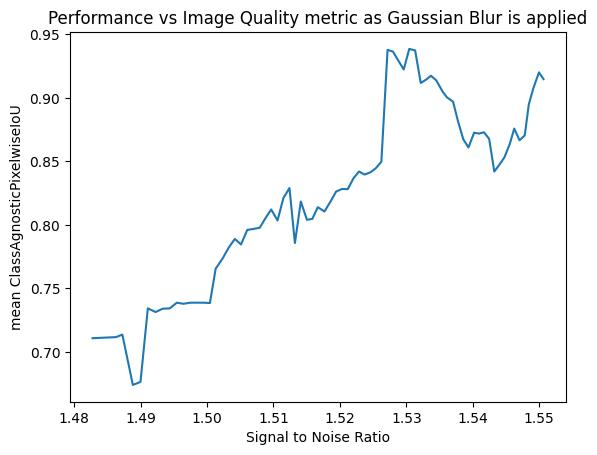

In [5]:
import torch  # type: ignore
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

curve, full = generator(
                blackbox_perturber_factories=[blur_perturber_factory],
                blackbox_detector=detector,
                blackbox_scorer=scorer,
                img_batch_size=img_batch_size,
                verbose=True
            )

img_quality_metrics = []
for size in [i for i in range(149, 0, -2)]: 
    perturber = GaussianBlurPerturber(ksize=size)
    augmentation = JATICDetectionAugmentation(perturber)
    aug_imgs, aug_dets, aug_metadata = augmentation(maite_dataset[0])
    img_quality_metrics.append(img_quality_metric.compute(aug_imgs[0]))

x = [data[0]['ksize'] for data in curve]
y = [data[1] for data in curve]

plt.cla()
plt.plot(img_quality_metrics, y)
plt.title('Performance vs Image Quality metric as Gaussian Blur is applied')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('mean ClassAgnosticPixelwiseIoU')

100%|██████████| 15/15 [00:58<00:00,  3.93s/it]


Text(0, 0.5, 'mean ClassAgnosticPixelwiseIoU')

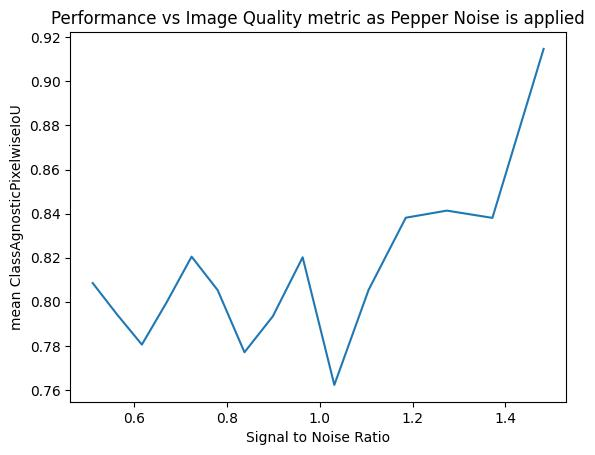

In [6]:
curve, full = generator(
                blackbox_perturber_factories=[noise_perturber_factory],
                blackbox_detector=detector,
                blackbox_scorer=scorer,
                img_batch_size=img_batch_size,
                verbose=True
            )
img_quality_metrics = []
for amount in [i*0.05 for i in range(15)]:
    perturber = PepperNoisePerturber(amount=amount)
    augmentation = JATICDetectionAugmentation(perturber)
    aug_imgs, aug_dets, aug_metadata = augmentation(maite_dataset[0])
    img_quality_metrics.append(img_quality_metric.compute(aug_imgs[0]))

x = [data[0]['amount'] for data in curve]
y = [data[1] for data in curve]

plt.cla()
plt.plot(img_quality_metrics, y)
plt.title('Performance vs Image Quality metric as Pepper Noise is applied')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('mean ClassAgnosticPixelwiseIoU')


After analysing the performance vs image metric graphs, Jack concludes that when the image metric falls below 1.4, the model performance drops past the acceptable level. He can then advise specific monitoring of the image quality metric that is collected to identify when the model is likely to suffer in quality.